<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

# Explore our Data & Preprocess

In [2]:
import os
# Create a path to the root folder and path to specific folders on my computer
data_path = "data/chest_xray/"

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

In [3]:
from PIL import Image

def detect_image_mode(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Check the number of channels
    num_channels = image.mode

    if num_channels == 'L':
        return "Black and White (Grayscale)"
    elif num_channels == 'RGB':
        return "Color (RGB)"
    else:
        return "Unknown"

# Example usage
image_path = r"data_color\chest_xray\train\NORMAL\IM-0115-0001.jpeg"
image_mode = detect_image_mode(image_path)
print(f"The image is in {image_mode} mode.")

The image is in Color (RGB) mode.


It seems that our images are actually greyscale meaning they have have 1 channel rather than 3 channels unlike RGB images. [reference pillow docs](https://pillow.readthedocs.io/en/stable/handbook/concepts.html)

In [4]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1080 normal images in the training set
There are 3107 pneumonia images in the training set
________________________________________________________________________________________
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 269 normal images in the validation set
There are 776 pneumonia images in the validation set


Lets preprocess the images by resizing to (128, 128, 3)

In [5]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (128, 128, 3)


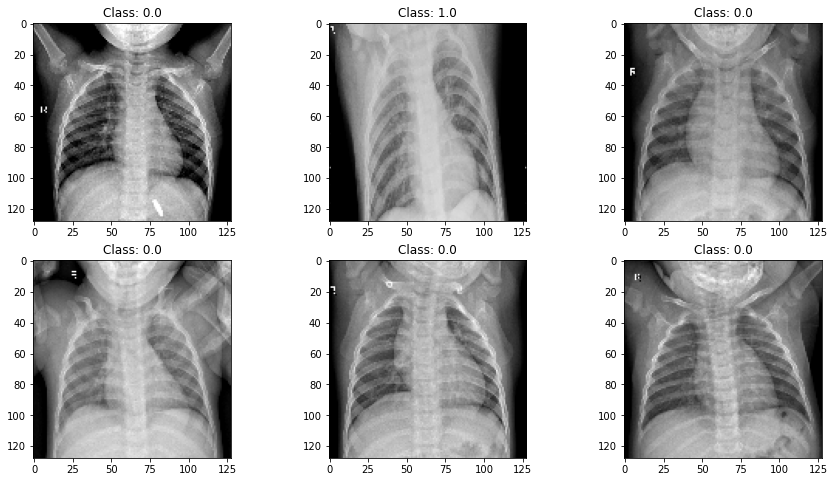

In [6]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

It seems images that arer very cloudy in the chest are Pneumonia while normal images are very clear. This means 1 is Pneumonia and 0 is Normal.

Image dimensions: (128, 128, 3)


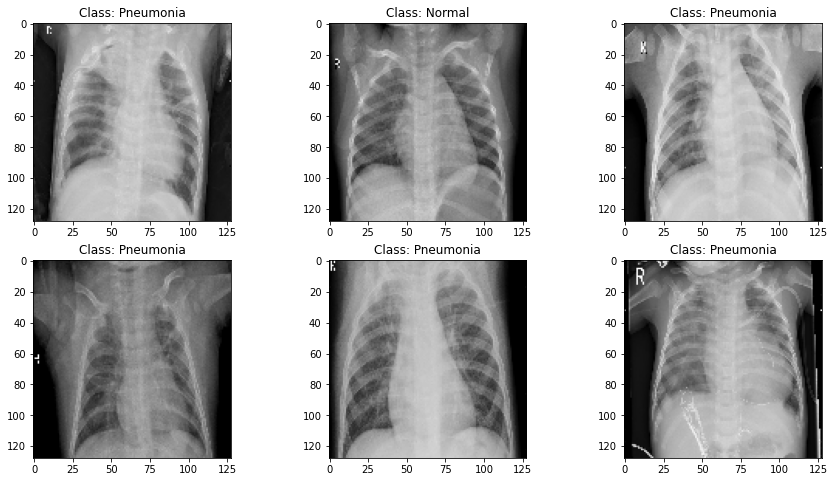

In [7]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [8]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
# Flatten layer to reshape the output
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(128, activation='relu'))

# Define the output 
model_mlp_base.add(Dense(1, activation='sigmoid'))


model_mlp_base.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,097,409
Trainable params: 2,097,409
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 24s 184ms/step - loss: 0.9681 - precision: 0.7424 - recall: 0.8861 - accuracy: 0.6874 - val_loss: 0.6743 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/30
131/131 [==============================] - 23s 178ms/step - loss: 0.6626 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.6514 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 3/30
131/131 [==============================] - 23s 177ms/step - loss: 0.6417 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.6325 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 4/30
131/131 [==============================] - 23s 178ms/step - loss: 0.6249 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.6173 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 5/30
131/131 [==============================] - 23s 179ms/step - loss: 0.6115 - precis

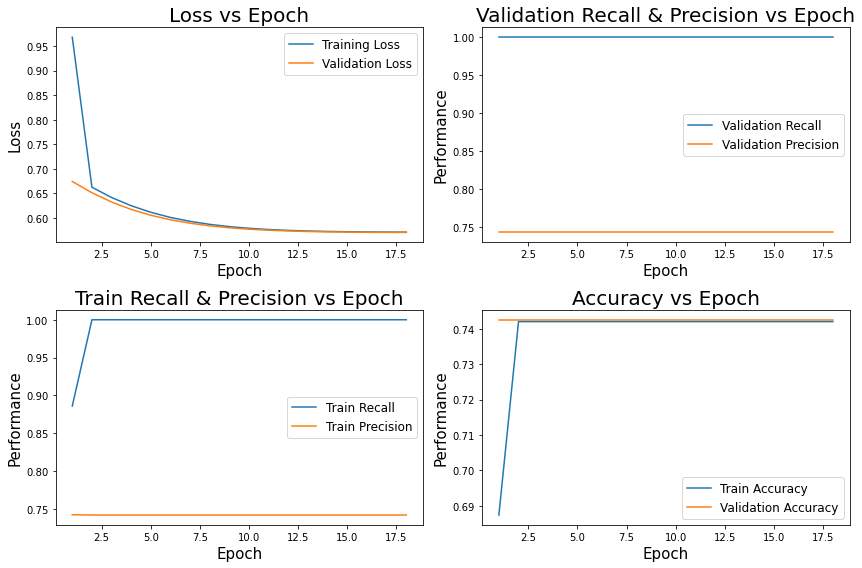

33/33 [==============================] - 4s 134ms/step - loss: 0.5772 - precision: 0.7426 - recall: 1.0000 - accuracy: 0.7426


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.577574,74.205875,100.0,74.205875
1,Test,0.670952,62.500000,100.0,62.500000
2,Validation,0.577155,74.258375,100.0,74.258375


In [10]:
from functions import train_model, view_history, model_evaluate

mlp = {}

# Train the model
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=30)

# View History 
view_history(mlp, 'Version1')

# Evaluate model
model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

It seems that we are generally still lowering both curves. We reach convergenace for both curves and dont overfit. It also seems that our learn rate might be too high since we start with a high train loss. Lets manually lower it slighlty and make our model deeper

# MLP Version 2

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 1)

# Define learn rate
learning_rate = (0.001 + 0.0001)/2

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(128, activation='relu'))
model_mlp_base_2.add(Dense(128, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 2,113,921
Trainable params: 2,113,921
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 25s 188ms/step - loss: 0.3769 - precision: 0.8343 - recall: 0.9547 - accuracy: 0.8464 - val_loss: 0.2099 - val_precision: 0.9649 - val_recall: 0.9201 - val_accuracy: 0.9158
Epoch 2/30
131/131 [==============================] - 24s 180ms/step - loss: 0.1771 - precision: 0.9467 - recall: 0.9607 - accuracy: 0.9307 - val_loss: 0.1572 - val_precision: 0.9721 - val_recall: 0.9433 - val_accuracy: 0.9378
Epoch 3/30
131/131 [==============================] - 23s 179ms/step - loss: 0.1469 - precision: 0.9589 - recall: 0.9681 - accuracy: 0.9455 - val_loss: 0.1485 - val_precision: 0.9375 - val_recall: 0.9858 - val_accuracy: 0.9407
Epoch 4/30
131/131 [==============================] - 24s 179ms/step - loss: 0.1369 - precision: 0.9615 - recall: 0.9646 - accuracy: 0.9451 - val_loss: 0.1429 - val_precision: 0.9736 - val_recall: 0.9523 - val_accuracy: 0.9455
Epoch 5/30
131/131 [==============================] - 24s 180ms/step - loss: 0.1640 - precis

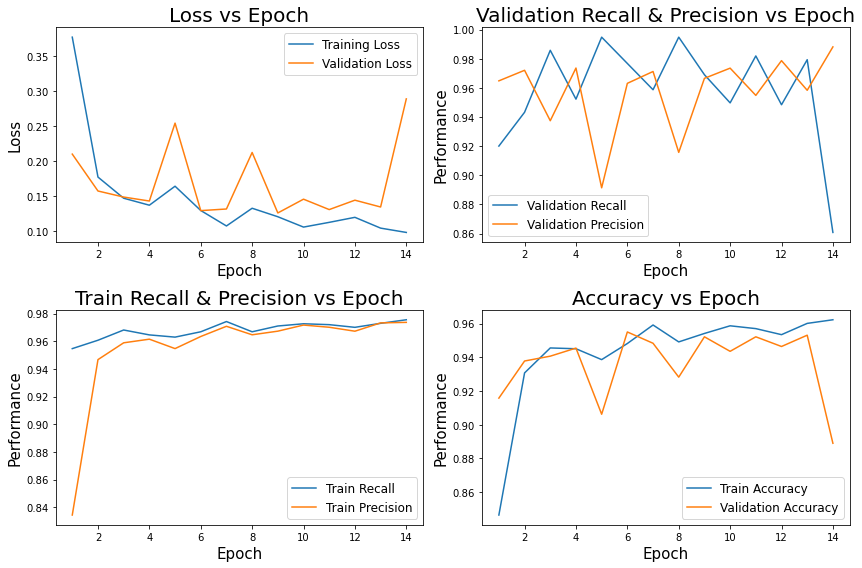

33/33 [==============================] - 4s 132ms/step - loss: 0.1292 - precision: 0.9632 - recall: 0.9768 - accuracy: 0.9550


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.092170,97.647440,97.521722,96.417481
1,Test,0.754222,72.865278,98.461539,76.121795
2,Validation,0.129171,96.315122,97.680414,95.502394


In [12]:
from functions import train_model, view_history, model_evaluate
mlp = {}

# Update our dictionary with Version 2
mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=30)

# View History
view_history(mlp, 'Version2')

# Evaluate model
model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

It seems that manually setting the learning rate did benefit us as our losses now are lower in general. It also seems we have not overfitted yet as the validation curve does not diverge upwards yet. It is still oscillating and lowering with the train curve. Lets make the model wider before deeper.

# MLP Version 3

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define leanring rate
learning_rate = (0.001 + 0.0001)/2

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(196, activation='relu'))
model_mlp_base_3.add(Dense(128, activation='relu'))


# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 196)               3211460   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               25216     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 3,236,805
Trainable params: 3,236,805
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 25s 190ms/step - loss: 0.3921 - precision: 0.8920 - recall: 0.9233 - accuracy: 0.8364 - val_loss: 0.1893 - val_precision: 0.9216 - val_recall: 0.9845 - val_accuracy: 0.9263
Epoch 2/30
131/131 [==============================] - 24s 180ms/step - loss: 0.2274 - precision: 0.9331 - recall: 0.9511 - accuracy: 0.9131 - val_loss: 0.3101 - val_precision: 0.9850 - val_recall: 0.8441 - val_accuracy: 0.8746
Epoch 3/30
131/131 [==============================] - 23s 179ms/step - loss: 0.1934 - precision: 0.9401 - recall: 0.9498 - accuracy: 0.9178 - val_loss: 0.4565 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8144
Epoch 4/30
131/131 [==============================] - 23s 179ms/step - loss: 0.1505 - precision: 0.9582 - recall: 0.9665 - accuracy: 0.9439 - val_loss: 0.1444 - val_precision: 0.9465 - val_recall: 0.9807 - val_accuracy: 0.9445
Epoch 5/30
131/131 [==============================] - 23s 179ms/step - loss: 0.1423 - precis

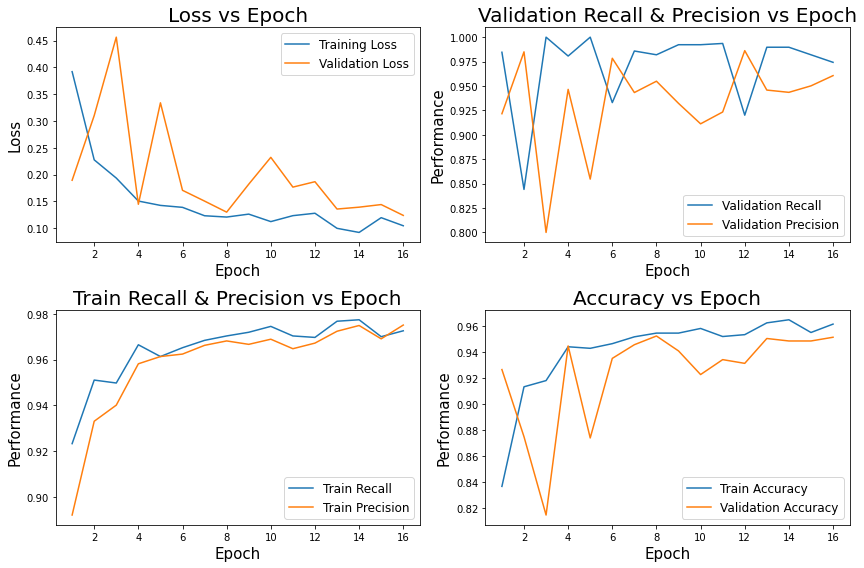

33/33 [==============================] - 5s 145ms/step - loss: 0.1297 - precision: 0.9549 - recall: 0.9820 - accuracy: 0.9522


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.086589,97.290403,98.229802,96.656317
1,Test,0.888738,71.296299,98.717946,74.358976
2,Validation,0.129739,95.488721,98.195875,95.215309


In [14]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=30)

# View history
view_history(mlp, 'Version3')

# Evaluate model
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

It still seems that we can generalize more. Both curves are still lowering and havent converged without diverging yet. Lets make the model deeper

# MLP Version 4

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define leanring rate
learning_rate = (0.001 + 0.0001)/2

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(196, activation='relu'))
model_mlp_base_4.add(Dense(128, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 196)               3211460   
_________________________________________________________________
dense_17 (Dense)             (None, 128)               25216     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 3,244,997
Trainable params: 3,244,997
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
131/131 [==============================] - 24s 184ms/step - loss: 0.3835 - precision: 0.8849 - recall: 0.9328 - accuracy: 0.8371 - val_loss: 0.1891 - val_precision: 0.9641 - val_recall: 0.9356 - val_accuracy: 0.9263
Epoch 2/20
131/131 [==============================] - 23s 179ms/step - loss: 0.1933 - precision: 0.9441 - recall: 0.9575 - accuracy: 0.9264 - val_loss: 0.1788 - val_precision: 0.9230 - val_recall: 0.9884 - val_accuracy: 0.9301
Epoch 3/20
131/131 [==============================] - 23s 179ms/step - loss: 0.1744 - precision: 0.9521 - recall: 0.9591 - accuracy: 0.9338 - val_loss: 0.1426 - val_precision: 0.9547 - val_recall: 0.9768 - val_accuracy: 0.9483
Epoch 4/20
131/131 [==============================] - 24s 182ms/step - loss: 0.1437 - precision: 0.9621 - recall: 0.9636 - accuracy: 0.9448 - val_loss: 0.2666 - val_precision: 0.8843 - val_recall: 0.9948 - val_accuracy: 0.8995
Epoch 5/20
131/131 [==============================] - 24s 183ms/step - loss: 0.1542 - precis

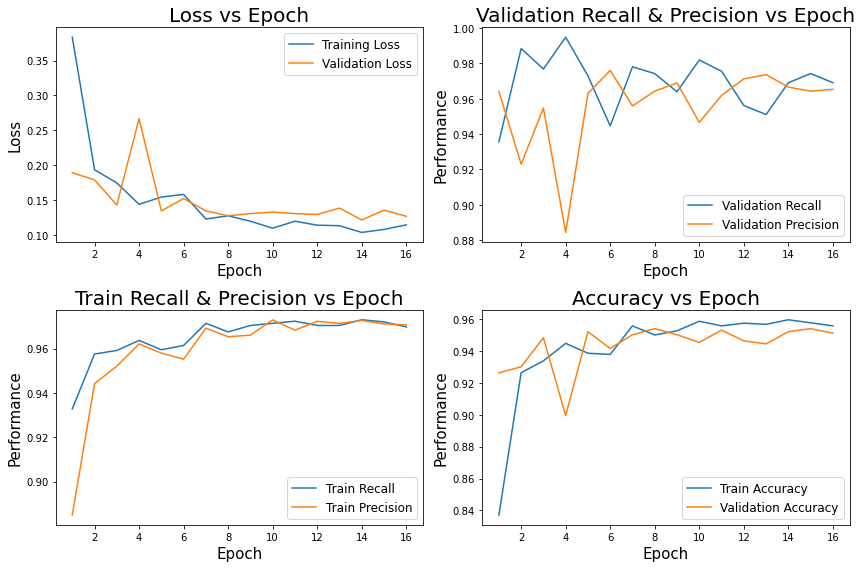

33/33 [==============================] - 4s 132ms/step - loss: 0.1273 - precision: 0.9643 - recall: 0.9742 - accuracy: 0.9541


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.088840,98.151749,97.425169,96.727967
1,Test,0.707023,73.704416,98.461539,77.083331
2,Validation,0.127256,96.428573,97.422683,95.406699


In [20]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=20)

# View history 
view_history(mlp, 'Version4')

# Evaluate model
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

It seems we keep doing better as the gaps are closing in on eachother. No overfit yet as our callback is ngating this from ocuring. Now make it wider again.

# MLP Version 5

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define leanring rate
learning_rate = (0.001 + 0.0001)/2

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(196, activation='relu'))
model_mlp_base_5.add(Dense(128, activation='relu'))
model_mlp_base_5.add(Dense(128, activation='relu'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 196)               3211460   
_________________________________________________________________
dense_21 (Dense)             (None, 128)               25216     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 3,253,317
Trainable params: 3,253,317
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
131/131 [==============================] - 25s 191ms/step - loss: 0.3279 - precision: 0.9007 - recall: 0.9462 - accuracy: 0.8648 - val_loss: 0.1762 - val_precision: 0.9337 - val_recall: 0.9794 - val_accuracy: 0.9330
Epoch 2/20
131/131 [==============================] - 25s 188ms/step - loss: 0.2008 - precision: 0.9395 - recall: 0.9553 - accuracy: 0.9212 - val_loss: 0.1747 - val_precision: 0.9254 - val_recall: 0.9910 - val_accuracy: 0.9340
Epoch 3/20
131/131 [==============================] - 24s 182ms/step - loss: 0.1610 - precision: 0.9539 - recall: 0.9582 - accuracy: 0.9346 - val_loss: 0.1388 - val_precision: 0.9605 - val_recall: 0.9716 - val_accuracy: 0.9493
Epoch 4/20
131/131 [==============================] - 24s 180ms/step - loss: 0.1469 - precision: 0.9582 - recall: 0.9672 - accuracy: 0.9444 - val_loss: 0.2146 - val_precision: 0.9123 - val_recall: 0.9923 - val_accuracy: 0.9234
Epoch 5/20
131/131 [==============================] - 24s 180ms/step - loss: 0.1494 - precis

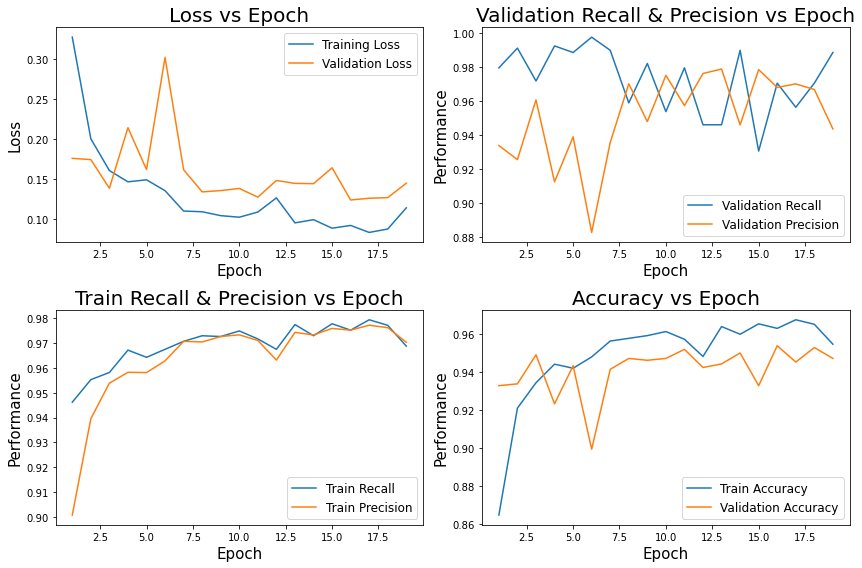

33/33 [==============================] - 5s 137ms/step - loss: 0.1277 - precision: 0.9572 - recall: 0.9794 - accuracy: 0.9522


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.079482,98.042363,98.326361,97.301173
1,Test,0.800359,71.428573,98.717946,74.519229
2,Validation,0.127686,95.717883,97.938144,95.215309


In [22]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=20)

# View history
view_history(mlp, 'Version5')

# Evaluate model 
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

We perform about the same in metrics but our loss curves seem much more better showing that adding another layer showed benefit in leanring. Now the gap between the curves is much smaller however it seems we are failing to capture some essential insights on the images because our test is not improving. We should call it and save our best MLP model and attempt data augmentation and see if it helps.

In [23]:
model_mlp_base_5.save("models/mlp5.keras")

## Data Augmentation MLP

In [24]:
from tensorflow.keras.models import load_model

mlp = load_model("models/mlp5.keras")

In [25]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


Epoch 1/30
131/131 [==============================] - 27s 210ms/step - loss: 0.5975 - precision: 0.7547 - recall: 0.9514 - accuracy: 0.7344 - val_loss: 0.4239 - val_precision: 0.9779 - val_recall: 0.9124 - val_accuracy: 0.9196
Epoch 2/30
131/131 [==============================] - 26s 200ms/step - loss: 0.5215 - precision: 0.7661 - recall: 0.9543 - accuracy: 0.7499 - val_loss: 0.3615 - val_precision: 0.9850 - val_recall: 0.8479 - val_accuracy: 0.8775
Epoch 3/30
131/131 [==============================] - 26s 199ms/step - loss: 0.5202 - precision: 0.7828 - recall: 0.9363 - accuracy: 0.7600 - val_loss: 0.3691 - val_precision: 0.9333 - val_recall: 0.9729 - val_accuracy: 0.9282
Epoch 4/30
131/131 [==============================] - 26s 200ms/step - loss: 0.4920 - precision: 0.7900 - recall: 0.9556 - accuracy: 0.7786 - val_loss: 0.2627 - val_precision: 0.9558 - val_recall: 0.9472 - val_accuracy: 0.9282
Epoch 5/30
131/131 [==============================] - 27s 204ms/step - loss: 0.4817 - precis

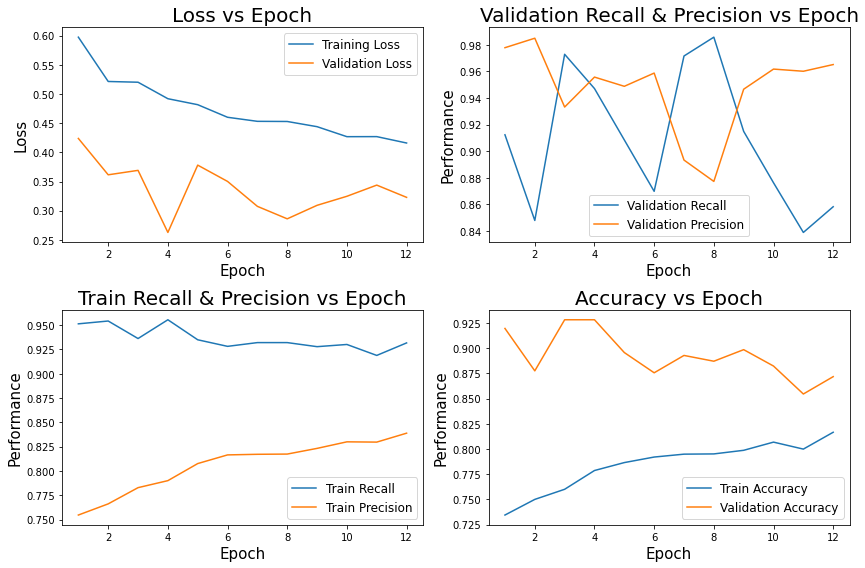

33/33 [==============================] - 4s 131ms/step - loss: 0.2627 - precision: 0.9558 - recall: 0.9472 - accuracy: 0.9282


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.466576,80.436563,94.882524,79.078096
1,Test,0.521554,73.107570,94.102561,74.679488
2,Validation,0.262706,95.578676,94.716495,92.822969


In [26]:
from functions import view_history, model_evaluate, train_model

# Train the model 
aug = {}

aug['Version1'] = train_model(mlp, train_gen_aug, val_gen_aug, 30)

# view history
view_history(aug, 'Version1')

# Evaluate model
model_evaluate(mlp, train_gen_aug, test_gen_aug, val_gen_aug)

We did slightly better but not by much. Lets attempt a Convolutional Network

# Convolutional Neural Network


Generally ConV networks do better for image classification because they can exploit the spatial structure images thus obtaining more information. 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_1.add(MaxPool2D(pool_size=(2,2), padding="valid"))

# Define the Dense Layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_1.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 63504)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8128640   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 8,129,217
Trainable params: 8,129,217
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 82s 627ms/step - loss: 0.7578 - precision: 0.7745 - recall: 0.9739 - accuracy: 0.7702 - val_loss: 0.3172 - val_precision: 0.9165 - val_recall: 0.9755 - val_accuracy: 0.9158
Epoch 2/30
131/131 [==============================] - 37s 286ms/step - loss: 0.2652 - precision: 0.9120 - recall: 0.9878 - accuracy: 0.9202 - val_loss: 0.3217 - val_precision: 0.8229 - val_recall: 1.0000 - val_accuracy: 0.8402
Epoch 3/30
131/131 [==============================] - 37s 281ms/step - loss: 0.2275 - precision: 0.9399 - recall: 0.9868 - accuracy: 0.9434 - val_loss: 0.2565 - val_precision: 0.8805 - val_recall: 0.9974 - val_accuracy: 0.8976
Epoch 4/30
131/131 [==============================] - 37s 286ms/step - loss: 0.2000 - precision: 0.9651 - recall: 0.9884 - accuracy: 0.9649 - val_loss: 0.2218 - val_precision: 0.8949 - val_recall: 0.9987 - val_accuracy: 0.9120
Epoch 5/30
131/131 [==============================] - 37s 281ms/step - loss: 0.1832 - precis

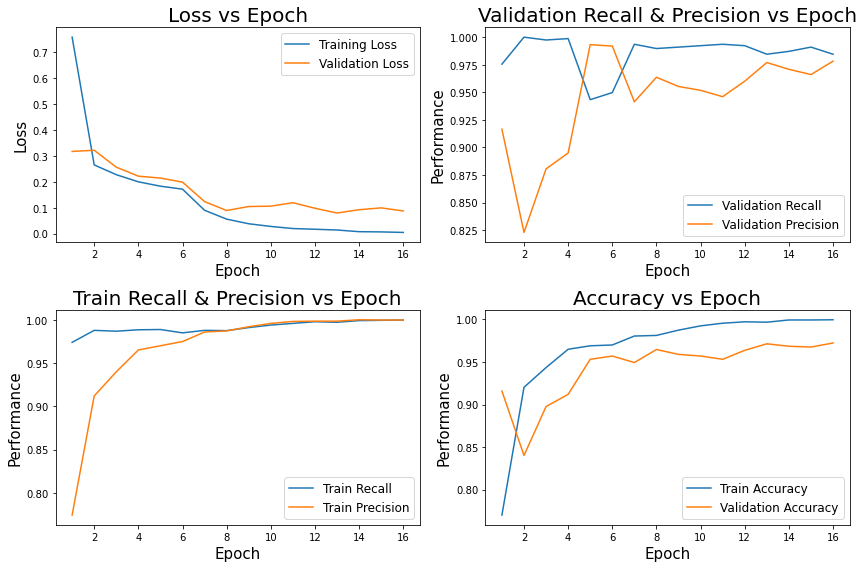

33/33 [==============================] - 6s 187ms/step - loss: 0.0893 - precision: 0.9636 - recall: 0.9897 - accuracy: 0.9646


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.037547,99.420100,99.324107,99.068546
1,Test,0.999275,70.727271,99.743587,74.038464
2,Validation,0.089343,96.361357,98.969072,96.459329


In [10]:
from functions import train_model, model_evaluate, view_history

cnn = {}

# Train model
cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 30)

# View history 
view_history(cnn, 'Version1')

# Evalaute model
model_evaluate(cnn_1, train_gen, test_gen, val_gen)

It seems we do well up until epoch 8. We have slight overfit. We can reduce the number of neurons to 96

# CNN Version 2

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_2 = Sequential()

# Define the layers
# Define our Conv layer
cnn_2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_2.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_2.add(Flatten())

# Define our Dense Layers
cnn_2.add(Dense(128, activation='relu'))
cnn_2.add(Dense(128, activation='relu'))

# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 63504)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8128640   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,145,729
Trainable params: 8,145,729
Non-trainable params: 0
______________________________________________

Epoch 1/30
131/131 [==============================] - 38s 288ms/step - loss: 0.3448 - precision: 0.8937 - recall: 0.9440 - accuracy: 0.8751 - val_loss: 0.1212 - val_precision: 0.9480 - val_recall: 0.9871 - val_accuracy: 0.9502
Epoch 2/30
131/131 [==============================] - 37s 282ms/step - loss: 0.1044 - precision: 0.9696 - recall: 0.9755 - accuracy: 0.9592 - val_loss: 0.1032 - val_precision: 0.9518 - val_recall: 0.9923 - val_accuracy: 0.9569
Epoch 3/30
131/131 [==============================] - 37s 285ms/step - loss: 0.0668 - precision: 0.9830 - recall: 0.9846 - accuracy: 0.9759 - val_loss: 0.0977 - val_precision: 0.9542 - val_recall: 0.9923 - val_accuracy: 0.9589
Epoch 4/30
131/131 [==============================] - 38s 288ms/step - loss: 0.0316 - precision: 0.9932 - recall: 0.9932 - accuracy: 0.9900 - val_loss: 0.1012 - val_precision: 0.9554 - val_recall: 0.9948 - val_accuracy: 0.9617
Epoch 5/30
131/131 [==============================] - 37s 285ms/step - loss: 0.0221 - precis

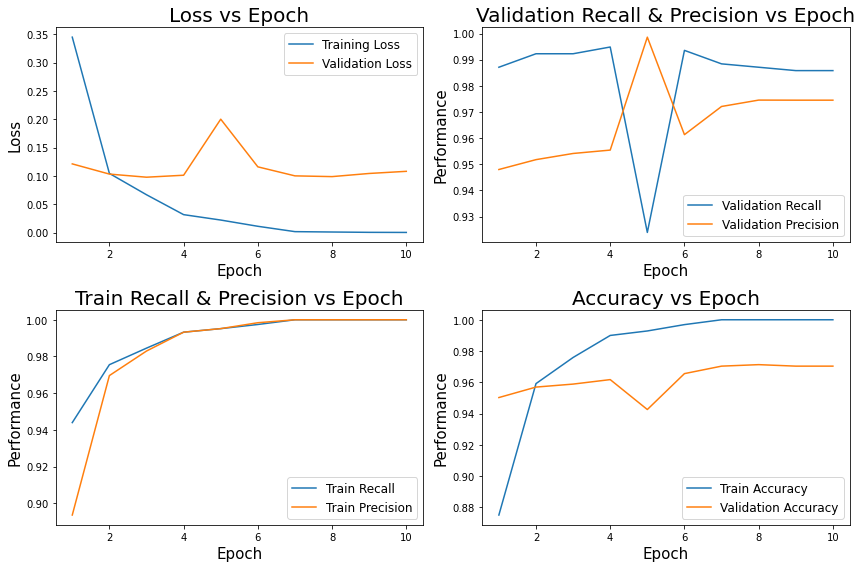

33/33 [==============================] - 6s 187ms/step - loss: 0.1032 - precision: 0.9518 - recall: 0.9923 - accuracy: 0.9569


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.060044,98.281348,99.388480,98.256510
1,Test,1.097687,69.784170,99.487180,72.756410
2,Validation,0.103215,95.179236,99.226803,95.693779


In [10]:
from functions import train_model, model_evaluate, view_history
cnn = {}

# Train the model
cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 30)

# View History 
view_history(cnn, "Version2")

# Evalauate Model
model_evaluate(cnn_2, train_gen, test_gen, val_gen)

The train curve looks much better but we definetly need to regualirze this

# CNN Version 3

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_3 = Sequential()

# Define the layers
# Define our Conv layer
cnn_3.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_3.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_3.add(Flatten())

# Define our Dense Layers
cnn_3.add(Dense(128, activation='relu'))
cnn_3.add(Dense(128, activation='relu', kernel_regularizer='l2'))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8128640   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 8,145,729
Trainable params: 8,145,729
Non-trainable params: 0
____________________________________________

Epoch 1/30
131/131 [==============================] - 38s 291ms/step - loss: 0.9811 - precision: 0.8989 - recall: 0.9503 - accuracy: 0.8615 - val_loss: 0.4520 - val_precision: 0.9277 - val_recall: 0.9923 - val_accuracy: 0.9368
Epoch 2/30
131/131 [==============================] - 37s 282ms/step - loss: 0.3366 - precision: 0.9705 - recall: 0.9726 - accuracy: 0.9577 - val_loss: 0.2982 - val_precision: 0.9893 - val_recall: 0.9549 - val_accuracy: 0.9589
Epoch 3/30
131/131 [==============================] - 37s 282ms/step - loss: 0.2265 - precision: 0.9846 - recall: 0.9865 - accuracy: 0.9785 - val_loss: 0.2259 - val_precision: 0.9844 - val_recall: 0.9768 - val_accuracy: 0.9713
Epoch 4/30
131/131 [==============================] - 37s 283ms/step - loss: 0.1754 - precision: 0.9910 - recall: 0.9887 - accuracy: 0.9850 - val_loss: 0.1942 - val_precision: 0.9794 - val_recall: 0.9781 - val_accuracy: 0.9684
Epoch 5/30
131/131 [==============================] - 37s 284ms/step - loss: 0.1326 - precis

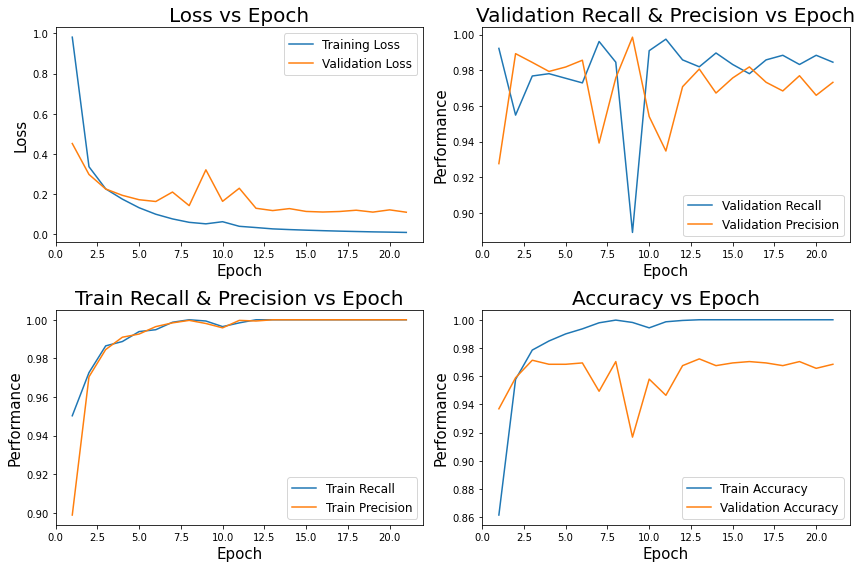

33/33 [==============================] - 6s 190ms/step - loss: 0.1185 - precision: 0.9807 - recall: 0.9820 - accuracy: 0.9722


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.025604,100.000000,100.000000,100.000000
1,Test,1.795564,71.062273,99.487180,74.358976
2,Validation,0.118469,98.069501,98.195875,97.224879


In [20]:
from functions import train_model, view_history, model_evaluate

# Train model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version3')

# Evaluate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

This is good. Now the gaps between the curves are closer. 

# CNN Version 4


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_4 = Sequential()

# Define the layers
# Define our Conv layer
cnn_4.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_4.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_4.add(Flatten())

# Define our Dense Layers
cnn_4.add(Dense(128, activation='relu'))
cnn_4.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_4.compile(optimizer=Adam(learning_rate=0.0005), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 63504)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8128640   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,145,729
Trainable params: 8,145,729
Non-trainable params: 0
______________________________________________

Epoch 1/30
131/131 [==============================] - 94s 714ms/step - loss: 7.8157 - precision: 0.8894 - recall: 0.9527 - accuracy: 0.8770 - val_loss: 4.0007 - val_precision: 0.9524 - val_recall: 0.9807 - val_accuracy: 0.9493
Epoch 2/30
131/131 [==============================] - 38s 289ms/step - loss: 2.4154 - precision: 0.9634 - recall: 0.9662 - accuracy: 0.9477 - val_loss: 1.3688 - val_precision: 0.9190 - val_recall: 0.9948 - val_accuracy: 0.9311
Epoch 3/30
131/131 [==============================] - 37s 283ms/step - loss: 0.8659 - precision: 0.9782 - recall: 0.9817 - accuracy: 0.9701 - val_loss: 0.6081 - val_precision: 0.9483 - val_recall: 0.9936 - val_accuracy: 0.9550
Epoch 4/30
131/131 [==============================] - 37s 281ms/step - loss: 0.4429 - precision: 0.9849 - recall: 0.9855 - accuracy: 0.9780 - val_loss: 0.3895 - val_precision: 0.9566 - val_recall: 0.9936 - val_accuracy: 0.9617
Epoch 5/30
131/131 [==============================] - 37s 279ms/step - loss: 0.3011 - precis

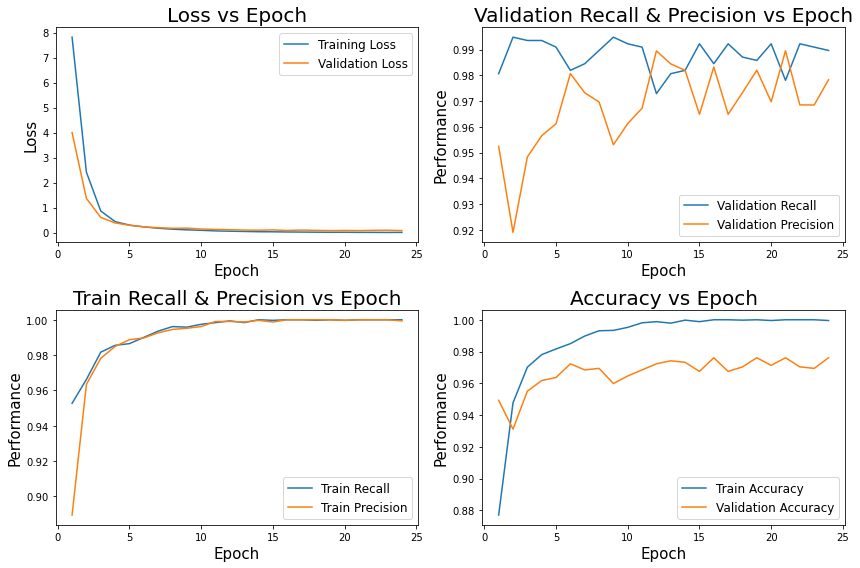

33/33 [==============================] - 6s 188ms/step - loss: 0.0874 - precision: 0.9833 - recall: 0.9845 - accuracy: 0.9761


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.022781,100.000000,100.000000,100.000000
1,Test,1.251945,71.639043,99.743587,75.160259
2,Validation,0.087426,98.326898,98.453611,97.607654


In [10]:
from functions import view_history, model_evaluate, train_model
# Train model
cnn = {}
cnn['Version4'] = train_model(cnn_4, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version4')

# Evaluate Model
model_evaluate(cnn_4, train_gen, test_gen, val_gen)

Now we are good. Lets attempt adding more covolutinal layers and see how we perform

# CNN Version 5 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_5 = Sequential()

# Define the layers
# Define our Conv layer
cnn_5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_5.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
cnn_5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid'))
cnn_5.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_5.add(Flatten())

# Define our Dense Layers
cnn_5.add(Dense(128, activation='relu'))
cnn_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_5.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_5.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Epoch 1/30
131/131 [==============================] - 38s 293ms/step - loss: 3.7694 - precision: 0.9006 - recall: 0.9611 - accuracy: 0.8715 - val_loss: 1.0033 - val_precision: 0.9645 - val_recall: 0.9794 - val_accuracy: 0.9579
Epoch 2/30
131/131 [==============================] - 37s 286ms/step - loss: 0.4731 - precision: 0.9740 - recall: 0.9755 - accuracy: 0.9625 - val_loss: 0.2264 - val_precision: 0.9695 - val_recall: 0.9845 - val_accuracy: 0.9656
Epoch 3/30
131/131 [==============================] - 38s 287ms/step - loss: 0.1678 - precision: 0.9787 - recall: 0.9781 - accuracy: 0.9680 - val_loss: 0.1415 - val_precision: 0.9793 - val_recall: 0.9768 - val_accuracy: 0.9675
Epoch 4/30
131/131 [==============================] - 38s 289ms/step - loss: 0.1127 - precision: 0.9789 - recall: 0.9836 - accuracy: 0.9721 - val_loss: 0.1210 - val_precision: 0.9694 - val_recall: 0.9807 - val_accuracy: 0.9627
Epoch 5/30
131/131 [==============================] - 38s 292ms/step - loss: 0.0996 - precis

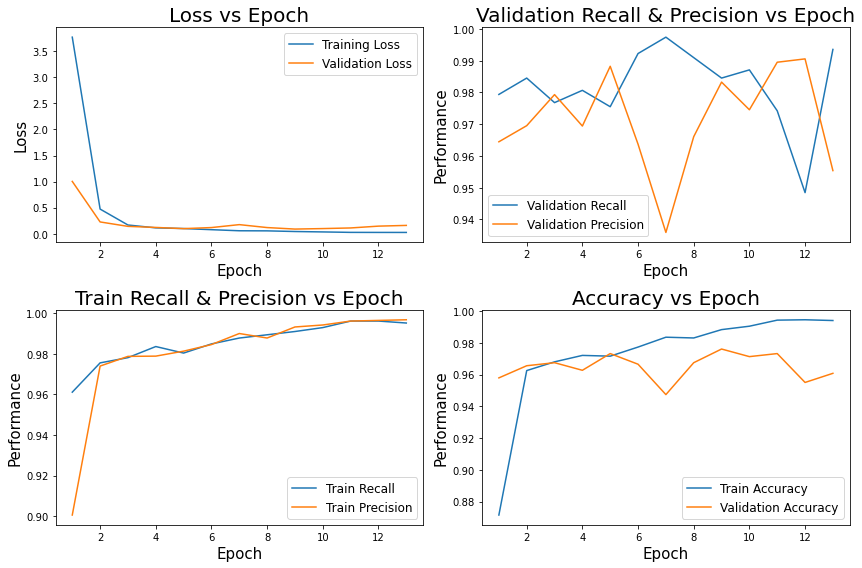

33/33 [==============================] - 6s 188ms/step - loss: 0.0982 - precision: 0.9883 - recall: 0.9755 - accuracy: 0.9732


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.065510,99.412340,98.004508,98.089325
1,Test,1.009247,73.434538,99.230766,77.083331
2,Validation,0.098208,98.825067,97.551548,97.320575


In [12]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version5'] = train_model(cnn_5, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version5')

# Evaluate Model
model_evaluate(cnn_5, train_gen, test_gen, val_gen)

We can still continue introducing complexity

# CNN Version 6

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_6 = Sequential()

# Define the layers
# Define our Conv layer
cnn_6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_6.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
cnn_6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid'))
cnn_6.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_6.add(Flatten())

# Define our Dense Layers
cnn_6.add(Dense(128, activation='relu'))
cnn_6.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_6.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_6.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

Epoch 1/30
131/131 [==============================] - 41s 314ms/step - loss: 4.7206 - precision: 0.9135 - recall: 0.9712 - accuracy: 0.8947 - val_loss: 0.9582 - val_precision: 0.9905 - val_recall: 0.9381 - val_accuracy: 0.9474
Epoch 2/30
131/131 [==============================] - 41s 310ms/step - loss: 0.4545 - precision: 0.9657 - recall: 0.9691 - accuracy: 0.9515 - val_loss: 0.2611 - val_precision: 0.9436 - val_recall: 0.9923 - val_accuracy: 0.9502
Epoch 3/30
131/131 [==============================] - 41s 310ms/step - loss: 0.1794 - precision: 0.9753 - recall: 0.9775 - accuracy: 0.9649 - val_loss: 0.1595 - val_precision: 0.9635 - val_recall: 0.9871 - val_accuracy: 0.9627
Epoch 4/30
131/131 [==============================] - 41s 314ms/step - loss: 0.1367 - precision: 0.9762 - recall: 0.9771 - accuracy: 0.9654 - val_loss: 0.1432 - val_precision: 0.9588 - val_recall: 0.9897 - val_accuracy: 0.9608
Epoch 5/30
131/131 [==============================] - 41s 310ms/step - loss: 0.0985 - precis

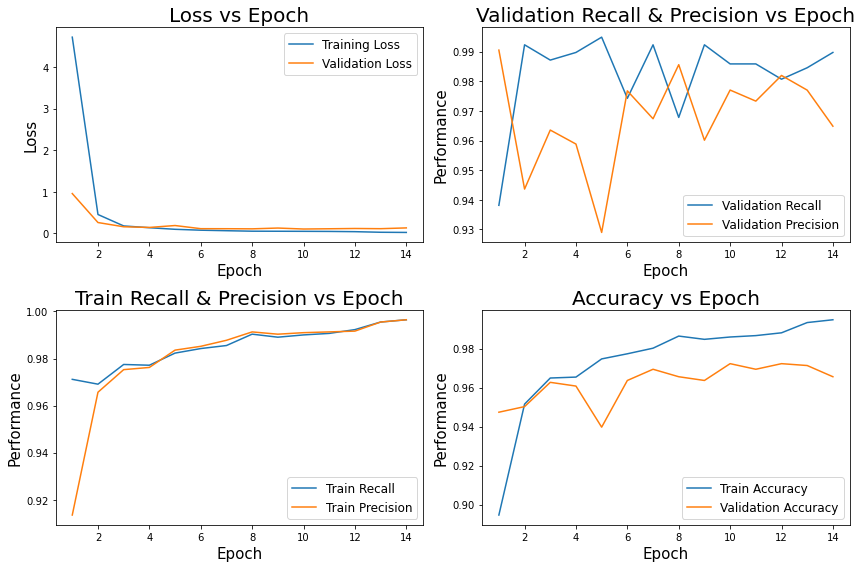

33/33 [==============================] - 6s 195ms/step - loss: 0.1135 - precision: 0.9767 - recall: 0.9742 - accuracy: 0.9636


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.068828,99.414062,98.294175,98.304278
1,Test,0.827406,73.069680,99.487180,76.762819
2,Validation,0.113451,97.674417,97.422683,96.363634


In [16]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version6'] = train_model(cnn_6, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version6')

# Evaluate Model
model_evaluate(cnn_6, train_gen, test_gen, val_gen)

We can see how we start to overfit with every epoch very slowly. lets go back a step 

# CNN version 7

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_7 = Sequential()

# Define the layers
# Define our Conv layer
cnn_7.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_7.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
cnn_7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid'))
cnn_7.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_7.add(Flatten())

# Define our Dense Layers 
cnn_7.add(Dense(256, activation='relu'))
cnn_7.add(Dropout(rate=0.5, seed=42))
cnn_7.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))
cnn_7.add(Dropout(rate=0.5, seed=42))


# Define output layer
cnn_7.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_7.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_7.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3686656   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

Epoch 1/30
131/131 [==============================] - 42s 323ms/step - loss: 5.2162 - precision: 0.8493 - recall: 0.9575 - accuracy: 0.8424 - val_loss: 0.5495 - val_precision: 0.9916 - val_recall: 0.9175 - val_accuracy: 0.9330
Epoch 2/30
131/131 [==============================] - 42s 318ms/step - loss: 0.2706 - precision: 0.9538 - recall: 0.9697 - accuracy: 0.9427 - val_loss: 0.2006 - val_precision: 0.9288 - val_recall: 0.9923 - val_accuracy: 0.9378
Epoch 3/30
131/131 [==============================] - 41s 315ms/step - loss: 0.1525 - precision: 0.9689 - recall: 0.9723 - accuracy: 0.9563 - val_loss: 0.1271 - val_precision: 0.9671 - val_recall: 0.9845 - val_accuracy: 0.9636
Epoch 4/30
131/131 [==============================] - 41s 316ms/step - loss: 0.1305 - precision: 0.9743 - recall: 0.9755 - accuracy: 0.9627 - val_loss: 0.1184 - val_precision: 0.9768 - val_recall: 0.9781 - val_accuracy: 0.9665
Epoch 5/30
131/131 [==============================] - 42s 317ms/step - loss: 0.1143 - precis

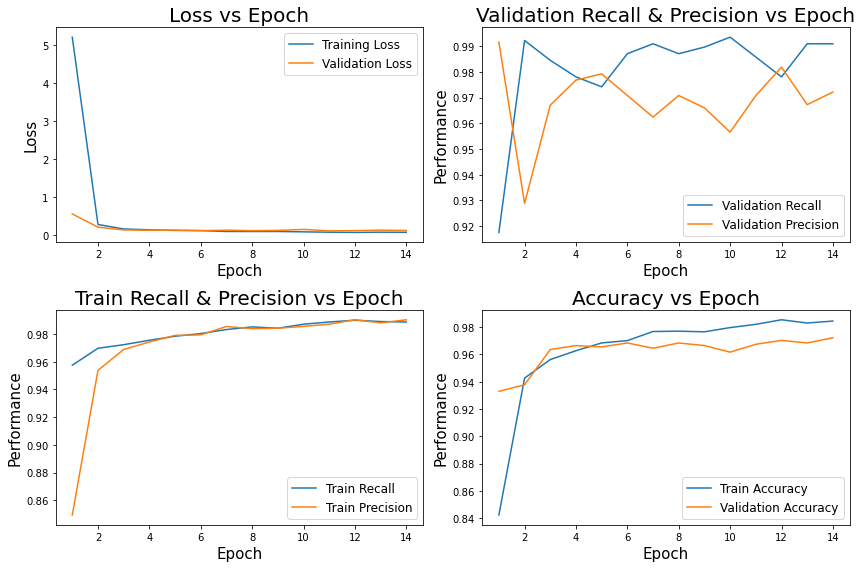

33/33 [==============================] - 6s 193ms/step - loss: 0.1096 - precision: 0.9708 - recall: 0.9871 - accuracy: 0.9684


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.073131,98.778135,98.873514,98.256510
1,Test,0.925520,71.376145,99.743587,74.839741
2,Validation,0.109627,97.084916,98.711342,96.842104


In [10]:
from functions import model_evaluate, train_model, view_history
cnn = {}

# Train model
cnn['Version7'] = train_model(cnn_7, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version7')

# Evaluate Model
model_evaluate(cnn_7, train_gen, test_gen, val_gen)

# CNN Version 8

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_8 = Sequential()

# Define the layers
# Define our Conv layer
cnn_8.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_8.add(MaxPool2D(pool_size=(2,2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_8.add(Flatten())

# Define our Dense Layers
cnn_8.add(Dense(196, activation='relu'))
cnn_8.add(Dropout(rate=0.40, seed=42))
cnn_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_8.add(Dropout(rate=0.40, seed=42))


# Define output layer
cnn_8.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_8.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_8.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               24893764  
_________________________________________________________________
dropout (Dropout)            (None, 196)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

Epoch 1/25
131/131 [==============================] - 47s 357ms/step - loss: 4.6809 - precision: 0.8475 - recall: 0.9195 - accuracy: 0.8175 - val_loss: 1.5396 - val_precision: 0.9736 - val_recall: 0.9497 - val_accuracy: 0.9435
Epoch 2/25
131/131 [==============================] - 47s 357ms/step - loss: 0.9051 - precision: 0.9675 - recall: 0.9688 - accuracy: 0.9527 - val_loss: 0.5052 - val_precision: 0.9564 - val_recall: 0.9897 - val_accuracy: 0.9589
Epoch 3/25
131/131 [==============================] - 46s 353ms/step - loss: 0.3538 - precision: 0.9804 - recall: 0.9820 - accuracy: 0.9721 - val_loss: 0.2562 - val_precision: 0.9920 - val_recall: 0.9601 - val_accuracy: 0.9646
Epoch 4/25
131/131 [==============================] - 46s 352ms/step - loss: 0.1793 - precision: 0.9868 - recall: 0.9855 - accuracy: 0.9795 - val_loss: 0.1596 - val_precision: 0.9934 - val_recall: 0.9678 - val_accuracy: 0.9713
Epoch 5/25
131/131 [==============================] - 46s 354ms/step - loss: 0.1097 - precis

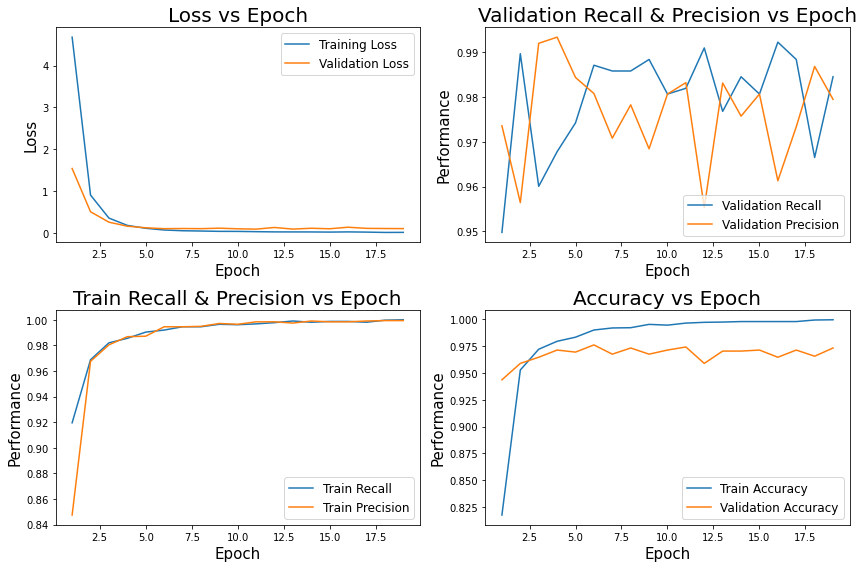

33/33 [==============================] - 7s 198ms/step - loss: 0.0894 - precision: 0.9832 - recall: 0.9820 - accuracy: 0.9742


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.016089,100.000000,100.000000,100.000000
1,Test,1.294461,71.376145,99.743587,74.839741
2,Validation,0.089433,98.322582,98.195875,97.416270


In [11]:
from functions import model_evaluate, train_model, view_history
cnn = {}
# Train model
cnn['Version 8'] = train_model(cnn_8, train_gen, val_gen, 25)

# View History 
view_history(cnn, 'Version 8')

# Evaluate model
model_evaluate(cnn_8, train_gen, test_gen, val_gen)

It seems the issue is actually model complexity. This models learns much better and is more stable. 

In [12]:
cnn_8.save("models/cnn8.keras")

# CNN Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data generators. 

In [21]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [22]:
from tensorflow.keras.models import load_model

cnn_aug = load_model("models/cnn8.keras")

In [23]:
from functions import model_evaluate, view_history, train_model
cnn_augmented = {}

# Train the model
cnn_augmented['Version1'] = train_model(cnn_aug, train_gen_aug, val_gen_aug, 30)


Epoch 1/30
131/131 [==============================] - 54s 414ms/step - loss: 0.5140 - precision: 0.8045 - recall: 0.9247 - accuracy: 0.7774 - val_loss: 0.2549 - val_precision: 0.9219 - val_recall: 0.9884 - val_accuracy: 0.9292
Epoch 2/30
131/131 [==============================] - 53s 407ms/step - loss: 0.4384 - precision: 0.8379 - recall: 0.9034 - accuracy: 0.7987 - val_loss: 0.2439 - val_precision: 0.9335 - val_recall: 0.9588 - val_accuracy: 0.9187
Epoch 3/30
131/131 [==============================] - 54s 410ms/step - loss: 0.3916 - precision: 0.8676 - recall: 0.9044 - accuracy: 0.8266 - val_loss: 0.2191 - val_precision: 0.9531 - val_recall: 0.9420 - val_accuracy: 0.9225
Epoch 4/30
131/131 [==============================] - 53s 408ms/step - loss: 0.3407 - precision: 0.8958 - recall: 0.9105 - accuracy: 0.8550 - val_loss: 0.1805 - val_precision: 0.9747 - val_recall: 0.9446 - val_accuracy: 0.9407
Epoch 5/30
131/131 [==============================] - 54s 412ms/step - loss: 0.3393 - precis

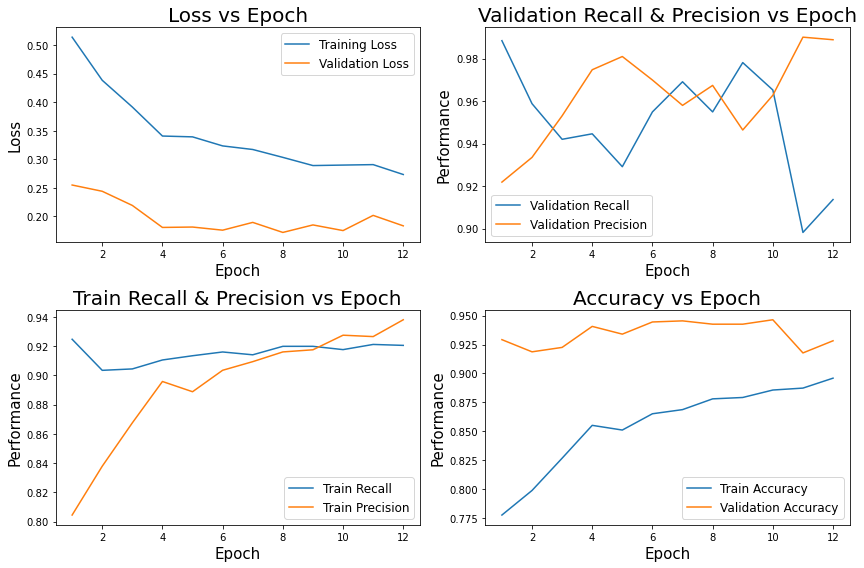

33/33 [==============================] - 6s 197ms/step - loss: 0.1805 - precision: 0.9747 - recall: 0.9446 - accuracy: 0.9407


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.293172,92.485547,92.693919,88.989729
1,Test,0.565534,77.731091,94.871795,79.807693
2,Validation,0.180528,97.473407,94.458765,94.066983


In [24]:
# Visualize history 
view_history(cnn_augmented, 'Version1')

# Evaluate model
model_evaluate(cnn_aug, train_gen_aug, test_gen_aug, val_gen_aug)

In [25]:
# Save our model from augmented training
cnn_aug.save("models/cnn_aug.keras")

Our losses in our test are much better. We even performed better by 7% in our Precision which is good news. As expected Recall stayed with high percentage since we have more positive instances in the dataset. The next step would be to take a pretrained architecture and attempt modeling this data rather than starting from scratch.

# Transfer Learning

Another method to use here would be to use an already pre trained network and see the results with our network. Lets use VGG19. To use it we need to process the data in a different way to be 224, 224, 3. 

In [9]:
from functions import process_data
# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(224, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [10]:
# Initialize Base
from keras.applications import VGG19
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (224, 224, 3)

# Load in the pretrained CNN
vgg19 = VGG19(
    weights='imagenet',
    input_shape=input_shape
    )

# Make configuration
transfer1 = Sequential()

# Add the vgg19 model
transfer1.add(vgg19)

# Since VGG19 is a convolutional architecture we should flatten the output
transfer1.add(Flatten())

# Define the same dense layers with our best cnn version that I made 
# Define our Dense Layers
transfer1.add(Dense(128, activation='relu'))
transfer1.add(Dense(128, activation='relu'))

# Define output layer
transfer1.add(Dense(1, activation='sigmoid'))

# Define the pretrained model as an exclusion from changing its weights since we do not want to change the VGG19 model
vgg19.trainable = False

transfer1.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(transfer1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 143,812,009
Trainable params: 144,769
Non-trainable params: 143,667,240
_________________________________________________________________
None


Epoch 1/400
131/131 [==============================] - 297s 2s/step - loss: 0.5837 - precision: 0.7427 - recall: 0.9932 - accuracy: 0.7397 - val_loss: 0.5607 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/400
131/131 [==============================] - 281s 2s/step - loss: 0.5458 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.5189 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 3/400
131/131 [==============================] - 280s 2s/step - loss: 0.4597 - precision: 0.7526 - recall: 0.9910 - accuracy: 0.7516 - val_loss: 0.3930 - val_precision: 0.8159 - val_recall: 0.9652 - val_accuracy: 0.8124
Epoch 4/400
131/131 [==============================] - 279s 2s/step - loss: 0.3593 - precision: 0.8613 - recall: 0.9231 - accuracy: 0.8326 - val_loss: 0.3502 - val_precision: 0.8732 - val_recall: 0.9317 - val_accuracy: 0.8488
Epoch 5/400
131/131 [==============================] - 275s 2s/step - loss: 0.3321 - precision: 

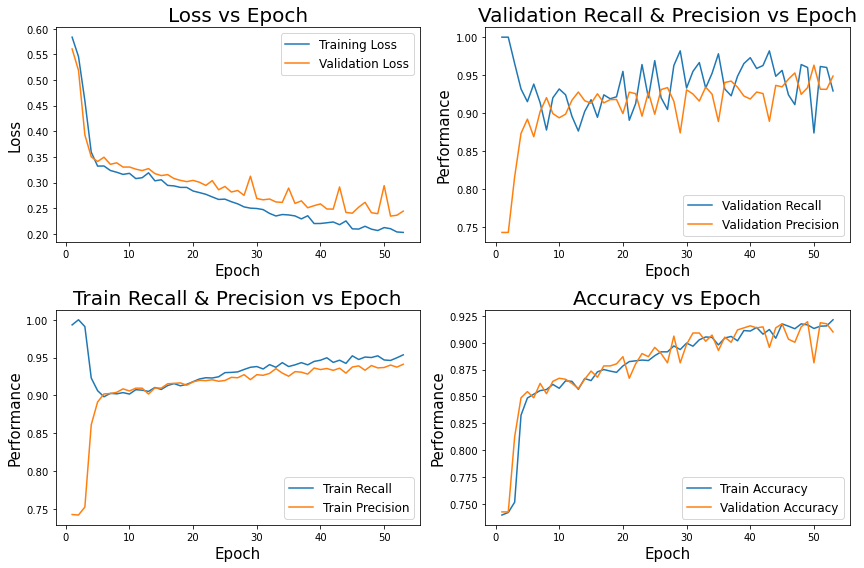

NameError: name 'train_gen_aug' is not defined

In [11]:
from functions import model_evaluate, view_history, train_model
vgg19_model = {}

# Train the model
vgg19_model['Version1'] = train_model(transfer1, train_gen, val_gen, 400)

# Visualize history 
view_history(vgg19_model, 'Version1')


In [12]:

# Evaluate model
model_evaluate(transfer1, train_gen, test_gen, val_gen)

33/33 [==============================] - 57s 2s/step - loss: 0.2402 - precision: 0.9345 - recall: 0.9562 - accuracy: 0.9177


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.202383,93.970168,95.300931,91.975158
1,Test,0.469519,77.439022,97.692305,80.769229
2,Validation,0.240192,93.450880,95.618558,91.770333


In [13]:
transfer1.save("models/vgg19_model.keras")

We did not perform much better compared to our models from scracth. There is also very minimal ovefit occuring

# VGG19 Data Augmentation

In [9]:
from functions import data_augmentation
# Create data augmented
train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(224, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


Epoch 1/400
131/131 [==============================] - 297s 2s/step - loss: 0.3717 - precision: 0.8840 - recall: 0.9005 - accuracy: 0.8385 - val_loss: 0.2982 - val_precision: 0.9492 - val_recall: 0.8918 - val_accuracy: 0.8842
Epoch 2/400
131/131 [==============================] - 281s 2s/step - loss: 0.3448 - precision: 0.8964 - recall: 0.8964 - accuracy: 0.8462 - val_loss: 0.3044 - val_precision: 0.9409 - val_recall: 0.9227 - val_accuracy: 0.8995
Epoch 3/400
131/131 [==============================] - 281s 2s/step - loss: 0.3386 - precision: 0.8977 - recall: 0.9038 - accuracy: 0.8522 - val_loss: 0.3325 - val_precision: 0.9565 - val_recall: 0.8505 - val_accuracy: 0.8603
Epoch 4/400
131/131 [==============================] - 278s 2s/step - loss: 0.3305 - precision: 0.9026 - recall: 0.8951 - accuracy: 0.8505 - val_loss: 0.3203 - val_precision: 0.9536 - val_recall: 0.8737 - val_accuracy: 0.8746
Epoch 5/400
131/131 [==============================] - 274s 2s/step - loss: 0.3309 - precision: 

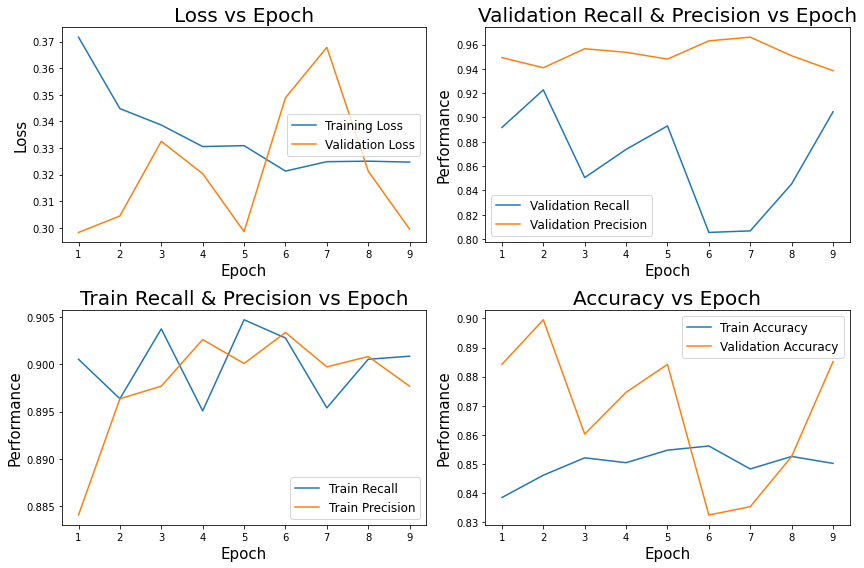

33/33 [==============================] - 52s 2s/step - loss: 0.2982 - precision: 0.9492 - recall: 0.8918 - accuracy: 0.8842


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.337267,87.719297,91.728354,84.332460
1,Test,0.442321,81.590909,92.051280,82.051283
2,Validation,0.298243,94.924551,89.175260,88.421053


In [10]:
from functions import model_evaluate, view_history, train_model
from tensorflow.keras.models import load_model

# Load our model
transfer2 = load_model("models/vgg19_model.keras")

vgg19_model = {}

# Train the model with augmented data
vgg19_model['Version2'] = train_model(transfer2, train_gen_aug, val_gen_aug, 400)

# Visualize history 
view_history(vgg19_model, 'Version2')

# Evaluate model
model_evaluate(transfer2, train_gen_aug, test_gen_aug, val_gen_aug)

In [11]:
transfer2.save("models/vgg19_aug.keras")

Using the pretrained architecture we see how our loss are similar acorss the board. We perform better using the VGG19 according to our metrics. Our model version does not perform as great as the pretrained conv network. The final evaluation should be using the VGG19 network. 